In [1]:
import pandas as pd
from tqdm.auto import tqdm


def fill_na(sample_ast):
    for node in sample_ast:
        node["children"] = node.get("children", None)
        node["value"] = node.get("value", None)
    return sample_ast

node_set = set()
ast_df_list = []

with open("../data/py150/python100k_train.json") as json_file:
    chunks = pd.read_json(json_file, lines=True, chunksize=1024)
    for samples in tqdm(chunks):
        for idx in samples.index:
            sample = samples.loc[idx].dropna()
            sample_ast = sample.values.tolist()
            filled_sample_ast = fill_na(sample_ast)
            ast_df = pd.DataFrame(filled_sample_ast)
            node_set.update(set(ast_df['type'].unique().tolist()))
            ast_df_list += [ast_df]
        break

0it [00:00, ?it/s]

In [2]:
train_ast_df = pd.DataFrame(ast_df_list, columns=["ast"])

/home/ken/.local/lib/python3.8/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [93]:
train_ast_df['node_num'] = train_ast_df['ast'].apply(lambda ast: ast.index.size)

In [94]:
for node_type in node_set:
    train_ast_df[f"{node_type}_count"] = train_ast_df['ast'].apply(lambda ast: ast[ast["type"] == node_type].index.size)

In [95]:
train_ast_df

,ast,node_num,TupleLoad_count,alias_count,ListLoad_count,Module_count,Expr_count,NameStore_count,ImportFrom_count,NameLoad_count,Assign_count,Str_count
0,type children \ 0 ...,116,34,4,1,1,1,1,4,34,1,35


In [7]:
import re


def count_casing(input_code):
    case_dict = {"lowerCamelCase": 0, "UpperCamelCase": 0, "snake_case": 0}
    lower_camel = r"[a-z]+([A-Z][a-z0-9]+)+"
    upper_camel = r"[A-Z][a-z]+([A-Z][a-z0-9]+)+"
    snake = r"[a-z]+(_[a-z0-9]+)+"
    input_code = input_code.replace("(", " ")
    input_code = input_code.replace(")", " ")
    for token in input_code.split():
        if re.match(lower_camel, token):
            case_dict["lowerCamelCase"] += 1
        elif re.match(upper_camel, token):
            case_dict["UpperCamelCase"] += 1
        elif re.match(snake, token):
            case_dict["snake_case"] += 1
    return case_dict


def count_docstrings(input_code):
    docstr = r"\"\"\"[\s\S]*?\"\"\"|\'\'\'[\s\S]*?\'\'\'"
    search = re.findall(docstr, input_code)
    doc_len = 0
    for docstring in search:
        doc_len += len(docstring)
    return len(search), doc_len


def count_comments(input_code):
    comment = r"#.*"
    search = re.findall(comment, input_code)
    comment_len = 0
    for comment in search:
        comment_len += len(comment)
    return len(search), comment_len

In [8]:
def read_file_to_string(filename):
    f = open(filename, "rb")
    s = ""
    try:
        s = f.read()
    except:
        print(filename)
    f.close()
    return s.decode(errors="replace")

In [9]:
test_code = read_file_to_string(f"./test_code.py")
test_code

'def function_name(par_1, parTwo, camelCase):\n\t\'\'\'\n\tdocstring time 1\n\t\'\'\'\n\t"""\n\tdocstring time 2\n\t"""\n    # single line comment\n\tvar_1 = 42 # cool and awesome comment\n\tprint(\'hello world!\') #comment too\n\treturn \n\ndef function_name2(par_1, parTwo, camelCase):\n\t\'\'\'\n\tdocstring time 1\n\t\'\'\'\n\t"""\n\tdocstring time 2\n\t"""\n    # single line comment\n\tvar_1 = 42 # cool and awesome comment\n\tprint(\'hello world!\') #comment too\n\treturn '

In [10]:
train_file_name = "../data/py150/py150_files/python100k_train.txt"
eval_file_name = "../data/py150/py150_files/python50k_eval.txt"

def read_train_data(file_name, batch_size=None):
    file_names = []
    with open(file_name, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break

            file_names += [line.strip()]

            if batch_size and len(file_names) >= batch_size:
                break

    return file_names

In [11]:
from tqdm import tqdm


def create_df(data):
    data_df = pd.DataFrame(data, columns=["file_name"])

    script_file_name_regex = re.compile(r"data/([^/]+)/([^/]+)/.+")

    usernames = []
    repos = []
    py_scripts = []
    snake = []
    lower_camel = []
    upper_camel = []
    docstrings = []
    doc_lens = []
    comments = []
    comment_lens = []
    line_counts = []

    for file_name in tqdm(data_df["file_name"]):

        match = script_file_name_regex.search(file_name)
        if not match:
            print(file_name)

        username = match.group(1)
        repo_name = match.group(2)

        file_string = read_file_to_string(f"../data/py150/py150_files/{file_name}")
        casing_count = count_casing(file_string)
        docstring_count, doc_len = count_docstrings(file_string)
        comment_count, comment_len = count_comments(file_string)

        usernames += [username]
        repos += [repo_name]
        py_scripts += [file_string]
        lower_camel += [casing_count["lowerCamelCase"]]
        upper_camel += [casing_count["UpperCamelCase"]]
        snake += [casing_count["snake_case"]]
        docstrings += [docstring_count]
        doc_lens += [doc_len]
        comments += [comment_count]
        comment_lens += [comment_len]
        line_counts += [len(file_string.split('\n'))]

    data_df["user_name"] = usernames
    data_df["repo_name"] = repos
    data_df["py_script"] = py_scripts
    data_df["lower_camel_case"] = lower_camel
    data_df["upper_camel_case"] = upper_camel
    data_df["snake_case"] = snake
    data_df["docstring"] = docstrings
    data_df["doc_len"] = doc_lens
    data_df["comment"] = comments
    data_df["comment_len"] = comment_lens
    data_df["line_count"] = line_counts

    return data_df

In [12]:
train_data = read_train_data(train_file_name)

In [13]:
print(len(train_data))

100000


In [14]:
train_data_df = create_df(train_data)

100%|██████████| 100000/100000 [02:22<00:00, 701.51it/s]


In [15]:
print(train_data_df["py_script"][0])

#!/usr/bin/env python
# -*- coding: utf-8 -*-

""" Provides ``mapping`` of url paths to request handlers.
"""

from bootstrap import Bootstrap
from fund import InstantPaymentNotificationHandler
from fund import ThankYouHandler
from view import *

mapping = [(
        r'/',
        Index
    ), (
        r'/ipn',
        InstantPaymentNotificationHandler
    ), (
        r'/thank-you',
        ThankYouHandler
    ), (
        r'/about\/?',
        About
    ), (
        r'/guide\/?',
        Guide
    ), (
        r'/guide/download\/?',
        Download
    ), (
        r'/guide/standards\/?',
        Standards
    ), (
        r'/community\/?',
        Community
    ), (
        r'/news\/?',
        News
    ), (
        r'/support\/?',
        Support
    ), (
        r'/contact\/?',
        Contact
    ), (
        r'/press\/?',
        Press
    ), (
        r'/legal/terms',
        Terms
    ), (
        r'/library\/?',
        Library
    ), (
        r'/library/sketchup\/?',
    

In [16]:
py_150_train_stats = {}
py_150_train_stats["user_count"] = train_data_df["user_name"].unique().size
py_150_train_stats["repo_count"] = train_data_df["repo_name"].unique().size

In [17]:
py_150_train_stats

{'user_count': 5632, 'repo_count': 7776}

In [18]:
eval_data = read_train_data(eval_file_name)[:1]
eval_data_df = create_df(eval_data)

100%|██████████| 1/1 [00:00<00:00, 584.82it/s]


In [19]:
py_150_eval_stats = {}
py_150_eval_stats["user_count"] = eval_data_df["user_name"].unique().size
py_150_eval_stats["repo_count"] = eval_data_df["repo_name"].unique().size
py_150_eval_stats

{'user_count': 1, 'repo_count': 1}

In [20]:
train_repo_df = train_data_df.apply(lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1)
eval_repo_df = eval_data_df.apply(lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1)

In [21]:
py_150_total_stats = {}
py_150_total_stats['repo_count'] = pd.concat([train_repo_df, eval_repo_df], ignore_index=True).unique().size
py_150_total_stats['user_count'] = pd.concat([train_data_df["user_name"], eval_data_df["user_name"]], ignore_index=True).unique().size
py_150_total_stats

{'repo_count': 7887, 'user_count': 5632}

In [22]:
train_data_df["user/repo"] = train_repo_df
eval_data_df["user/repo"] = eval_repo_df

In [23]:
watch_count = pd.read_csv("../data/watch_count_public_data.csv")
watch_count = watch_count.rename(columns={"repo_name": "user/repo"}).drop(columns="Record Count")

In [24]:
train_data_df_wc = train_data_df.join(watch_count.set_index('user/repo'), on='user/repo')
train_data_df_wc['watch_count'].size, train_data_df_wc['watch_count'].isna().sum()

(100000, 21630)

In [25]:
eval_data_df_wc = eval_data_df.join(watch_count.set_index('user/repo'), on='user/repo')
eval_data_df_wc['watch_count'].size, eval_data_df_wc['watch_count'].isna().sum()

(1, 1)

In [26]:
train_data_df_wc['script_len'] = train_data_df_wc['py_script'].apply(lambda script: len(script))
eval_data_df_wc['script_len'] = eval_data_df_wc['py_script'].apply(lambda script: len(script))

In [27]:
train_data_df_wc['comment_density'] = train_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['comment_len']/row['script_len'], axis=1)
eval_data_df_wc['comment_density'] = eval_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['comment_len']/row['script_len'], axis=1)


In [28]:
train_data_df_wc['doc_density'] = train_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['doc_len']/row['script_len'], axis=1)
eval_data_df_wc['doc_density'] = eval_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['doc_len']/row['script_len'], axis=1)

In [153]:
# train_data_df_wc.to_csv("py150k_train_stats.csv", index=False)
# eval_data_df_wc.to_csv("py150k_eval_stats.csv", index=False)

In [29]:
train_plot_df = train_data_df_wc.dropna(subset=['watch_count'])
train_plot_df = train_plot_df[train_plot_df["watch_count"] > 10]
train_plot_df

,file_name,user_name,repo_name,py_script,lower_camel_case,upper_camel_case,snake_case,docstring,doc_len,comment,comment_len,line_count,user/repo,watch_count,script_len,comment_density,doc_density
1,data/0rpc/zerorpc-python/zerorpc/events.py,0rpc,zerorpc-python,# -*- coding: utf-8 -*-\n# Open Source Initiat...,0,15,23,0,0,24,1244,363,0rpc/zerorpc-python,139.0,10694,0.116327,0.000000
2,data/0xadada/dockdj/app/manage.py,0xadada,dockdj,"#!/usr/bin/env python\n""""""Django's command lin...",0,0,2,1,36,1,21,13,0xadada/dockdj,12.0,288,0.072917,0.125000
13,data/4Catalyzer/flask-resty/tests/test_composi...,4Catalyzer,flask-resty,"from flask_resty import Api, GenericModelView\...",0,11,44,0,0,2,158,167,4Catalyzer/flask-resty,13.0,3837,0.041178,0.000000
16,data/9miao/Firefly/firefly/dbentrust/memclient.py,9miao,Firefly,#coding:utf8\n'''\nCreated on 2013-7-10\nmemca...,1,4,4,14,287,5,36,105,9miao/Firefly,55.0,2690,0.013383,0.106691
17,data/9miao/Firefly/firefly/test/test_dbentrust.py,9miao,Firefly,#coding:utf8\n'''\nCreated on 2013-7-31\n\n@au...,0,0,0,1,58,9,388,46,9miao/Firefly,55.0,1236,0.313916,0.046926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99977,data/HIPS/Kayak/tests/check_MemoryUse.py,HIPS,Kayak,import numpy as np\nimport numpy.random...,0,0,0,0,0,1,62,22,HIPS/Kayak,12.0,477,0.129979,0.000000
99978,data/HIPS/Kayak/tests/test_NExp.py,HIPS,Kayak,import numpy as np\nimport numpy.random...,0,0,15,0,0,0,0,141,HIPS/Kayak,12.0,3359,0.000000,0.000000
99979,data/HIPS/autograd/autograd/scipy/signal.py,HIPS,autograd,from __future__ import absolute_import\nimport...,0,1,61,0,0,5,120,140,HIPS/autograd,263.0,5930,0.020236,0.000000
99980,data/HIPS/autograd/examples/sinusoid.py,HIPS,autograd,from __future__ import absolute_import\nfrom _...,0,0,12,0,0,4,103,46,HIPS/autograd,263.0,1098,0.093807,0.000000


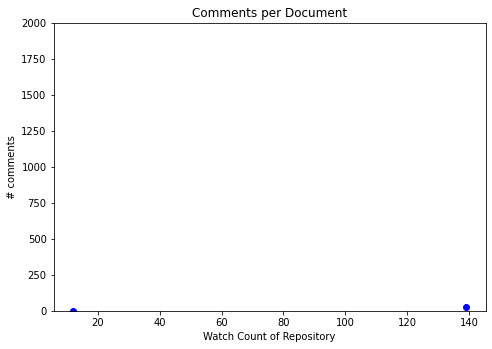

In [40]:
import matplotlib.pyplot as plt
X = train_plot_df['watch_count'].tolist()
Y = train_plot_df['comment'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 2000])
ax.scatter(X, Y, color='b')
plt.title("Comments per Document")
plt.ylabel('# comments')
plt.xlabel('Watch Count of Repository')
plt.show()

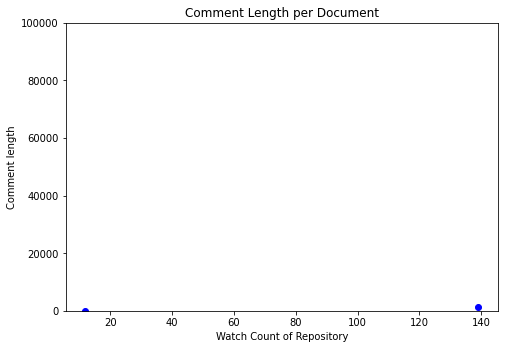

In [41]:

Y = train_plot_df['comment_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 100000])
ax.scatter(X, Y, color='b')
plt.title("Comment Length per Document")
plt.ylabel('Comment length')
plt.xlabel('Watch Count of Repository')
plt.show()

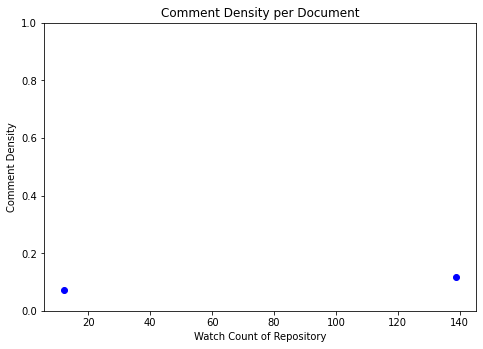

In [42]:

Y = train_plot_df['comment_density'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.scatter(X, Y, color='b')
plt.title("Comment Density per Document")
plt.ylabel('Comment Density')
plt.xlabel('Watch Count of Repository')
plt.show()

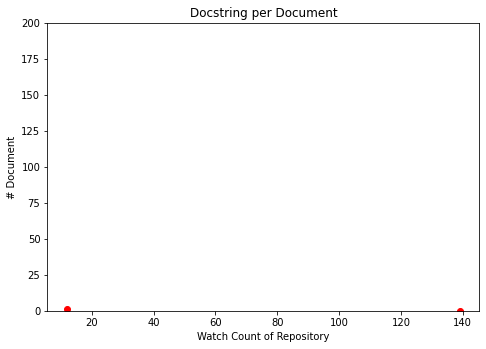

In [43]:

Y = train_plot_df['docstring'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 200])
ax.scatter(X, Y, color="r")
plt.title("Docstring per Document")
plt.ylabel('# Document')
plt.xlabel('Watch Count of Repository')
plt.show()

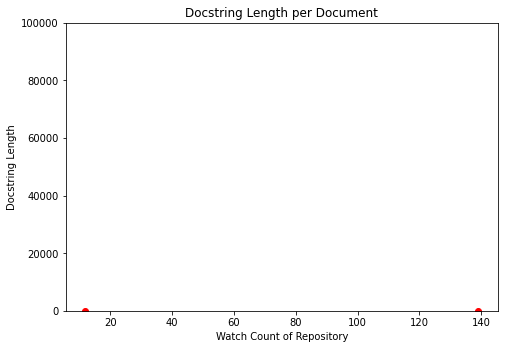

In [44]:

Y = train_plot_df['doc_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 100000])
ax.scatter(X, Y, color="r")
plt.title("Docstring Length per Document")
plt.ylabel('Docstring Length')
plt.xlabel('Watch Count of Repository')
plt.show()

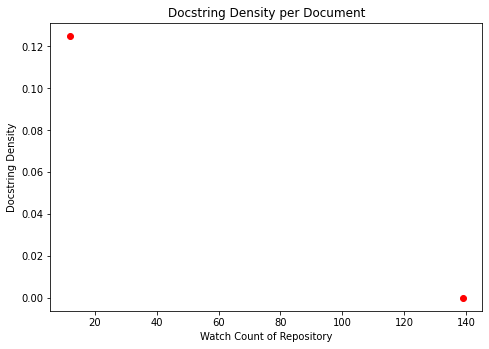

In [45]:
Y = train_plot_df['doc_density'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color='r')
plt.title("Docstring Density per Document")
plt.ylabel('Docstring Density')
plt.xlabel('Watch Count of Repository')
plt.show()

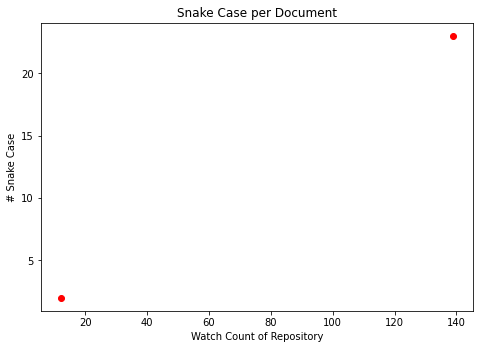

In [46]:
Y = train_plot_df['snake_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="r")
plt.title("Snake Case per Document")
plt.ylabel('# Snake Case')
plt.xlabel('Watch Count of Repository')
plt.show()

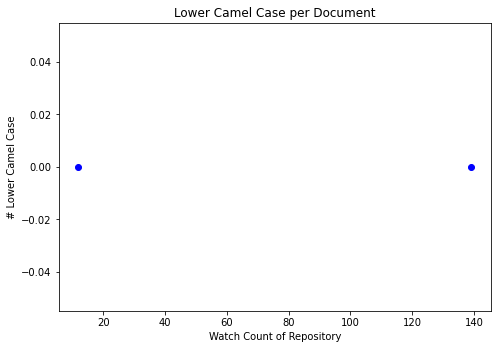

In [47]:
Y = train_plot_df['lower_camel_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="b")
plt.title("Lower Camel Case per Document")
plt.ylabel('# Lower Camel Case')
plt.xlabel('Watch Count of Repository')
plt.show()

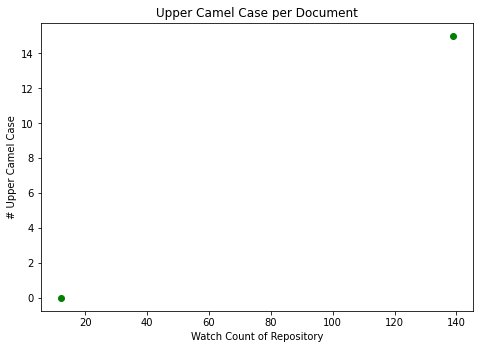

In [48]:
Y = train_plot_df['upper_camel_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="g")
plt.title("Upper Camel Case per Document")
plt.ylabel('# Upper Camel Case')
plt.xlabel('Watch Count of Repository')
plt.show()

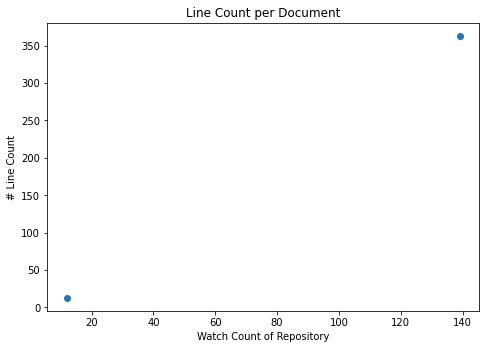

In [49]:
Y = train_plot_df['line_count'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y)
plt.title("Line Count per Document")
plt.ylabel('# Line Count')
plt.xlabel('Watch Count of Repository')
plt.show()

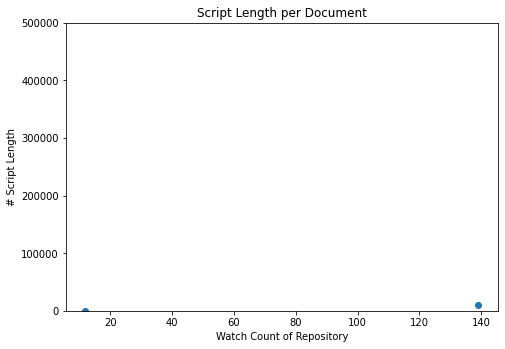

In [50]:
Y = train_plot_df['script_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 500000])
ax.scatter(X, Y)
plt.title("Script Length per Document")
plt.ylabel('# Script Length')
plt.xlabel('Watch Count of Repository')
plt.show()

In [53]:
_bool_df = train_data_df_wc[train_data_df_wc['lower_camel_case'] > 100]['py_script'].apply(lambda script: "django" in script.lower())
# print(train_data_df_wc[train_data_df_wc['lower_camel_case'] > 100]['py_script'][_bool_df].loc[55901])

In [54]:
# train_data_df_wc.loc[55901]['file_name']

In [55]:
train_ast_df

,ast,node_num,TupleLoad_count,alias_count,ListLoad_count,Module_count,Expr_count,NameStore_count,ImportFrom_count,NameLoad_count,Assign_count,Str_count
0,type children \ 0 ...,116,34,4,1,1,1,1,4,34,1,35


In [31]:
# sample_data = read_train_data(train_file_name, 1)
# sample_data_df = create_df(sample_data)
# print(len(sample_data))
sample_data_df = train_data_df

In [32]:
sample_data_df['script_len'] = sample_data_df['py_script'].apply(lambda script: len(script))
sample_data_df['comment_density'] = sample_data_df.apply(lambda row: 0 if row['script_len']==0 else row['comment_len']/row['script_len'], axis=1)
sample_data_df['doc_density'] = sample_data_df.apply(lambda row: 0 if row['script_len']==0 else row['doc_len']/row['script_len'], axis=1)

In [40]:
print(sample_data_df["py_script"][99])

#!/usr/bin/env python
#
# Copyright 2007 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#







"""An extremely simple WSGI web application framework.

This module is an alias for the webapp2 module i.e. the following are
equivalent:

1. from google.appengine.ext import webapp
2. import webapp2 as webapp

It exports three primary classes: Request, Response, and RequestHandler. You
implement a web application by subclassing RequestHandler. As WSGI requests come
in, they are passed to 

In [59]:
sample_ast = train_ast_df['ast'][0]

In [60]:
sample_script = sample_data_df["py_script"][0]

In [61]:

def extract_casing(input_code):
    case_dict = {"lowerCamelCase": [], "UpperCamelCase": [], "snake_case": []}
    lower_camel = r"[a-z]+([A-Z][a-z0-9]+)+"
    upper_camel = r"[A-Z][a-z]+([A-Z][a-z0-9]+)+"
    snake = r"[a-z]+(_[a-z0-9]+)+"
    
    input_code = input_code.replace("(", " ")
    input_code = input_code.replace(")", " ")
    for token in input_code.split():
        if re.match(lower_camel, token):
            case_dict["lowerCamelCase"] += [token]
        elif re.match(upper_camel, token):
            case_dict["UpperCamelCase"] += [token]
        elif re.match(snake, token):
            case_dict["snake_case"] += [token]
    return case_dict
    

In [62]:
casings = extract_casing(sample_script)
print(casings)

{'lowerCamelCase': [], 'UpperCamelCase': ['InstantPaymentNotificationHandler', 'ThankYouHandler', 'InstantPaymentNotificationHandler', 'ThankYouHandler', 'RedirectSuccess', 'RedirectError', 'RedirectAfterDelete', 'ActivityScreen', 'TxnList', 'MessageStrings', 'NotFound'], 'snake_case': []}


In [64]:
# sample_ast['ast']['casing'] = [None]
# for case, identifiers in casings.items():
#     for value in identifiers:
#         sample_ast[sample_ast['value'] == value]['casing'] = case
        

TypeError: can't multiply sequence by non-int of type 'tuple'

In [73]:
sample_ast["type"].unique()

array(['Module', 'Expr', 'Str', 'ImportFrom', 'alias', 'Assign',
       'NameStore', 'ListLoad', 'TupleLoad', 'NameLoad'], dtype=object)

In [85]:
sample_ast["value"].notnull()

0      False
1      False
2       True
3       True
4       True
       ...  
111     True
112     True
113    False
114     True
115     True
Name: value, Length: 116, dtype: bool

In [87]:
sample_ast[sample_ast["value"].notnull()]["type"].unique()

array(['Str', 'ImportFrom', 'alias', 'NameStore', 'NameLoad'],
      dtype=object)

In [ ]:
# {CLASS_NAME: {snake: 1, camel:200}, vairable: {}}
# {CLASS_NAME: {snake: 200, camel:200}}

In [ ]:
test_key = "Expr"
sample = None
for idx, ast in enumerate(ast_df_list):
    type_list = ast["type"].unique().tolist()
    if test_key in type_list:
        print(idx)
        sample = ast
        # test_sample = sample[sample["value"].notnull()][sample["type"] == test_key]
        # if len(test_sample) > 0:
        #     print(test_sample)
        nodes = [node for expr_children in sample[sample["type"] == test_key]["children"] for node in expr_children]
        for idx in nodes:
            print(sample.loc[idx])

In [171]:
print(train_data_df_wc.loc[7]["py_script"])

# -*- coding: utf-8 -*-
##############################################################################
#
# Copyright (c) 2010-2015, 2degrees Limited.
# All Rights Reserved.
#
# This file is part of django-wsgi <https://github.com/2degrees/django-wsgi/>,
# which is subject to the provisions of the BSD at
# <http://dev.2degreesnetwork.com/p/2degrees-license.html>. A copy of the
# license should accompany this distribution. THIS SOFTWARE IS PROVIDED "AS IS"
# AND ANY AND ALL EXPRESS OR IMPLIED WARRANTIES ARE DISCLAIMED, INCLUDING, BUT
# NOT LIMITED TO, THE IMPLIED WARRANTIES OF TITLE, MERCHANTABILITY, AGAINST
# INFRINGEMENT, AND FITNESS FOR A PARTICULAR PURPOSE.
#
##############################################################################
"""
Exceptions raised by :mod:`django_wsgi.`

"""

__all__ = ("DjangoWSGIException", "ApplicationCallError")


class DjangoWSGIException(Exception):
    """Base class for exceptions raised by :mod:`django_wsgi`."""
    pass


class ApplicationCallErro